In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras

I recommend you to go through the article over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) to cover all the concepts which is required to build our own summarizer

#Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.

#Custom Attention Layer

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. We will go with the latter option for this article. You can download the attention layer from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) and copy it in a different file called attention.py.

Let’s import it into our environment:

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import numpy as np
import pandas as pd 
import re
import zipfile
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import sys
from glob import glob
from keras.utils import plot_model
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# import google drive上的module .py

root_path = '/content/drive/My Drive'
folder_path = root_path + '/Deep Learning/How-to-build-own-text-summarizer-using-deep-learning-master'
root_path = '/content/drive/My Drive/Deep Learning/How-to-build-own-text-summarizer-using-deep-learning-master'
if not root_path in sys.path:
  print('新增路徑')
  sys.path.append(root_path)
if not root_path in sys.path:
  print('新增路徑')
  sys.path.append(root_path)
for p in sys.path:
  print(p)

新增路徑

/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
/content/drive/My Drive
/content/drive/My Drive/Deep Learning/How-to-build-own-text-summarizer-using-deep-learning-master


In [0]:
from attention import AttentionLayer

#Import the Libraries

In [0]:
for i in glob('./*'):
  print(i)

./dataset
./drive
./sample_data


In [0]:
zip_path = folder_path + '/amazon-fine-food-reviews.zip'
zfile = zipfile.ZipFile(zip_path)
zfile.extractall('dataset/amazon-fine-food-reviews') # 解壓縮到colab上的資料夾，不要解壓縮到google drive，資料太多會爆掉
print(glob('dataset/amazon-fine-food-reviews/*'))    # 解壓縮到colab裡dataset會看到lymphoma資料夾

['dataset/amazon-fine-food-reviews/database.sqlite', 'dataset/amazon-fine-food-reviews/Reviews.csv', 'dataset/amazon-fine-food-reviews/hashes.txt']


#Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. Feel free to use the entire dataset for training your model if your machine has that kind of computational power.

In [0]:
data=pd.read_csv("./dataset/amazon-fine-food-reviews/Reviews.csv",nrows=100000)
data.loc[[0]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...


# Drop Duplicates and NA values

# <font color='blue'>1.去除重複的評論、刪除含有null資料的列</font>

In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates 指定column'Text'，刪除該行所有重複的資料
data.dropna(axis=0,inplace=True)#dropping na ，axis=0刪除列，若該列裡有任一欄的資料為null，就整列刪除，axis=1刪除行

# Information about dataset

Let us look at datatypes and shape of the dataset

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


#Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

**<font color='blue'>re.sub()：</font>**

inputStr = "hello 111 world 111"

replacedStr = inputStr.replace("111", "222")

-->inputStr變成"hello 222 world 222"

若inputStr改為 = "hello 123 world 456"

若想同時把123和456，都换成222，就無法直接透過單一次的replace完成

可用正則表示式達到目的
replacedStr = re.sub("\d+", "222", inputStr)

**<font color='blue'>'\\d'：匹配數字，寫法等同於 [0-9]</font>**

**<font color='blue'>'+'：匹配前一字元 1 至多次</font>**

**<font color='blue'>[xyz]：字元的集合。會匹配中括號[ ]內所有字元</font>**

[a-d] 等同於 [abcd]。會匹配 "brisket" 的 "b" 、"city" 的 'c' ……等。 而/[a-z.]+/ 和 /[\w.]+/ 均可匹配字串 "test.i.ng" 

**<font color='blue'>字串前面加上'r'：是為了告訴編譯器這個字串是raw string，將'\\'看成普通的字元就好，不要編譯backslash '\\'</font>**

例如，\n 在raw string中，是2個字元，'\'和'n'，
若不是raw string，會被編譯轉成換行符號

例：

r"a\n\nb" -->六個字元'a','\','n','\','n','b'

 "a\n\nb" -->'\n'會被編譯成換行符號，'a'換行換行'b'

 'a'

換行
 
 'b'

 ---------------
**<font color='blue'>[^abc]：中括號[ ]中寫入的字元將被否定，匹配非出現在中括號[ ]中的符號，</font>**

[^abc]可以寫作[^a-c]。

"brisket"中不匹配(a,b,c,)，所以會找到'r'、"chop."中找到 'h'。

**<font color='blue'>\\：(1)若後面接特殊字元，能將任何特殊字元，恢復成一般字元。(2)若後面接非特殊字元，可代表特殊功能</font>**

'\\\\'：代表'\\'這個字元。'\\('：代表'('這個字元

'b'：找出小寫 b；若改為'\b'：代表的是邊界功能

**<font color='blue'>\*：匹配前一個字元 0 至多次。</font>**

'a*' 後面有0個或多個a的意思

/bo*/ 匹配「A ghost booooed」中的 boooo、「A bird warbled」中的 b，但在「A goat grunted」中不會匹配任何字串。

**<font color='blue'>\b：	吻合文字邊界。</font>**

/\bter\b/.test("interest")：'ter'不是邊界-->false

/\bter\b/.test("in ter est")：'ter'是邊界-->true

	
**<font color='blue'>{n}：規定字元確切出現的次數，n為正整數</font>**

例如：/a{2}/無法在 "candy" 找到、但在"caandy"能找到'aa'；若字串擁有2個以上 "caaandy" 還是只會認前面2個。

**<font color='blue'>{n,m}：規定字元出現的次數，n為至少、m為至多出現次數，其n、m皆為正整數</font>**

/a{1,3}/ 無法在 "cndy" 匹配到；而在 "candy" 中的第1個"a"符合；在 "caaaaaaandy" 中的前3個 "aaa" 符合，雖然此串有許多a，但只認前面3個。

# <font color='blue'>2.建立停用詞字典，建立清理評論的function(去除評論裡的停用詞、去除評論裡只有一個字母的詞)</font>

In [0]:
stop_words = set(stopwords.words('english')) 

In [0]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString) # 取出'(' & 出現多次0至多次的非')'的字元 & ')'字元，取代換成空字串''
                                                    # -->將字串中含有括號()的字元與括號裡的字元全部取代成空字串
    newString = re.sub('"','', newString)           # 將 " 字元，取代成空字串

    # 將newString用空格切開，切開後為list，
    # 檢查list中每一項的詞，若該詞出現在字典contraction_mapping的key裡面-->就將該詞轉換成字典裡的value
    # 反之，該詞不變動
    # 轉換完後的list再用空格' '.join起來，例如'-'.join([a,b])-->'a-b'
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 

    newString = re.sub(r"'s\b","",newString) # 找到字串's，且's要為邊界，aa's-->true, 'saa-->false
    newString = re.sub("[^a-zA-Z]", " ", newString) # 非a-zA-Z的字元，全部轉成空格' '
    newString = re.sub('[m]{2,}', 'mm', newString) # 出現2次以上的m(mm,mmm,mmmm...)，全部轉成'mm'
    if(num==0):
      # 對newString依照空格切開，對於每個詞w，若w不在stop_words裡面，就把w放進此list
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens: # 對每個放在tokens裡的詞，若詞的長度>1(即不是只有一個字母)，就放進long_words list裡
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# <font color='blue'>3.對每一筆評論做清理(若評論裡的詞存在於"停用詞字典"裡就刪掉)，清理完放進cleaned_text 的list裡</font>

In [0]:
#call the function
cleaned_text = []
for t in data['Text']: # 對每一筆評論
    cleaned_text.append(text_cleaner(t,0)) # 去除非英文字母字、()、"、's、這些字元、去除出現在stop_words裡面的詞、去除長度為1的字元

Let us look at the first five preprocessed reviews

In [0]:
cleaned_text[:5]  # 取得前五筆清理過後的評論

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

# <font color='blue'>3.對每一筆摘要做清理(不需刪掉停用詞)，清理完放進cleaned_summary 的list裡</font>

In [0]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))# 去除非英文字母字、()、"、's、這些字元、去除長度為1的字元，不去除出現在stop_words裡面的詞

Let us look at the first 10 preprocessed summaries

In [0]:
cleaned_summary[:10] # 取出前10筆摘要

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [0]:
data['cleaned_text']=cleaned_text # 清理過後的評論
data['cleaned_summary']=cleaned_summary # 清理過後的摘要

#Drop empty rows

# <font color='blue'>4.將空字串的資料取代為np.nan，再用dropna刪除掉含有null資料的row</font>

In [0]:
data.replace(, np.nan, inplace=True) # 去除空的row ，inplace=True直接修改原dataframe
data.dropna(axis=0,inplace=True) # axis=0: 刪除包含缺失值的行、axis=1: 刪除包含缺失值的列

#Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

# <font color='blue'>5.計算每一筆清理後的評論有幾個詞，存進text_word_count的list裡</font>
# <font color='blue'>5.計算每一筆清理後的摘要有幾個詞，存進summary_word_count的list裡</font>

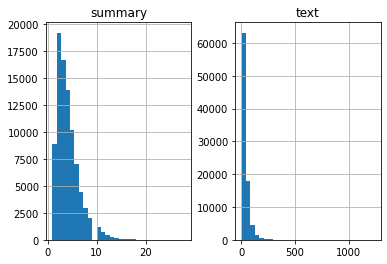

In [0]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split())) # 紀錄每一筆評論，詞的數量

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split())) # 紀錄每一筆摘要，詞的數量

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30) # 將dataframe畫直方圖，bins區間數量，圖形畫出來要有幾條長方形。
plt.show()
# 由圖可知，大部分的摘要的詞，數量都在8個詞以下

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [0]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8): # 計算詞數量 <=8的摘要
        cnt=cnt+1
print(cnt/len(data['cleaned_summary'])) # 計算詞數量 <=8的摘要，佔全部摘要的幾成-->有94%的摘要，詞數量都<=8

0.9424907471335922


# <font color='blue'>6.訂出每筆資料的詞數量上限，讓每筆評論、摘要長度一樣長，評論：30、摘要：8</font>

We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [0]:
max_text_len=30   # 將評論的詞數量限定在30以下
max_summary_len=8 # 將摘要的詞數量限制在8以下

# <font color='blue'>7.檢查每一筆清理後的評論與摘要，若詞數量皆<=上限，就存進short_text、short_summary的list裡，建立一新的DataFrame，存進符合長度的評論與摘要</font>

<font color='brown'>這樣做會刪掉長度>上限的資料，為什麼不直接用padding截長補短就好了</font>

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])
print(cleaned_text.shape, cleaned_summary.shape)

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)): # 清乾淨的每一筆評論
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len): # 只留下詞數量<指定長度 的資料
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary}) # 去掉過長的資料，存進dataframe
df.loc[[0]]

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food


Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

# <font color='blue'>8.對每一筆摘要，加上\<start\>tag(這裡是sostok)、\<end\>tag(這裡是eostok)  </font>

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok') # 對summary裡的資料，加上'開頭'、'結尾'
df.loc[[0]]

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

# <font color='blue'>9.分出90%訓練用(x_tr、y_tr)、10%測試用資料(x_val、y_val)，將Series轉成np.array再傳進train_test_split()</font>

In [0]:
from sklearn.model_selection import train_test_split # 分出訓練用、測試用資料
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

print(type(x_tr))

#Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

#Text Tokenizer

# <font color='blue'>10.利用Tokenizer()建立詞庫</font>
# <font color='blue'>fit_on_texts()傳入list，給予出現的每個詞一個詞庫的index編號</font>

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr)) # 訓練用資料 將每個字轉成辭庫

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

# <font color='blue'>11.定一門檻值:4，將出現次數<4次的詞視為稀有詞</font>
# <font color='blue'>稀有詞的比例佔所有詞中66%，出現次數僅佔所有詞出現次數的2%</font>

In [0]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items(): # dict(詞:出現次數)
    tot_cnt=tot_cnt+1        # 總共有幾個詞
    tot_freq=tot_freq+value  # 全部詞的總出現次數
    if(value<thresh):  # 定一個"次數"門檻值
        cnt=cnt+1      # 紀錄出現次數<4次的詞，總共幾筆，總共次數，找出稀有詞
        freq=freq+value
        print(key,value)
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)  # 出現次數<4次的詞 占所有詞的比例  稀有詞的比例
print("Total Coverage of rare words:",(freq/tot_freq)*100) # <4次的詞的出現次數，佔所有詞出現總次數的比例

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [0]:
print(x_tr.shape) # 訓練資料有41346筆，每一筆的長度為30

(41346, 30)


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with top most common words for reviews.

# <font color='blue'>12.利用**Tokenizer()**建立詞庫(指定詞庫大小=詞總數-稀有詞數目)，</font>
- # <font color='blue'>因為**fit_on_texts()**是照詞的出現次數排序，出現次數最多的index排在愈前面，即稀有詞因為出現次數少，不會被排進詞庫裡面</font>
- # <font color='blue'>執行**texts_to_sequences()**時，會將每一筆資料的詞轉換成詞庫裡的index，若該詞不存在於詞庫裡就會刪除-->即轉換後的評論"稀有詞"就被刪除了</font>
- # <font color='blue'>執行**pad_sequences()**時，將每筆list截長補短到指定長度:30，因為我們前面就將長度>上限的評論去掉了，所以這裡實際上只做"補短"</font>
- # <font color='blue'>**.num_words**：詞庫的大小，有幾個放詞的位子(index)</font>


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   # num_words詞庫最多容納幾個詞(出現頻率最高的幾個詞) = 所有詞的數量 - 稀有詞的數量 (詞庫裡不放稀有詞)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)  # 將每個詞改以該詞的index表示，詞出現頻率太低不在詞庫裡的詞會被刪掉，轉換完只顯示在詞庫裡詞
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

# t = Tokenizer(num_words=5) # 只取詞頻率最高的5-1個詞放進詞庫
# S = ['Look! The quick brown fox jumps over the lazy dog.', 'haha my bad dog']
# t.fit_on_texts(S)  # 正常构造成S: List[str]
# seq = t.texts_to_sequences(S)
# [[3, 1, 4, 1, 2], [2]] # index只有1~4，the出現頻率最高index=1、dog頻率第二index=2...

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post') # 將詞list補到指定長度，截長補短，padding='pre'前端補0,'pose'後端補0
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1  # 詞庫的大小，因為有用pad_sequences，所以詞庫大小要+1 padding是補index = 0

In [0]:
x_voc

8440

#Summary Tokenizer

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

# <font color='blue'>13.定一門檻值:6，將出現次數<6次的詞視為稀有詞</font>
# <font color='blue'>稀有詞的比例佔所有詞中78%，出現次數僅佔所有詞出現次數的5%</font>

In [0]:
thresh=6 # 設門檻值

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


Let us define the tokenizer with top most common words for summary.

# <font color='blue'>14.利用**Tokenizer()**建立詞庫(指定詞庫大小=詞總數-稀有詞數目)，即轉換後的摘要"稀有詞"就被刪除了</font>

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let us check whether word count of start token is equal to length of the training data

In [0]:
y_tokenizer.word_counts['sostok'],len(y_tr)   # sostok 出現次數

(42453, 42453)

Here, I am deleting the rows that contain only **START** and **END** tokens

# <font color='blue'>15.刪除空白的摘要，若摘要只有2個詞，即只有START and END tag，代表該摘要為空</font>
<font color='brown'>前面不是已經把空字串''轉成np.nan，再dropna了，那應該不會有''空白的資料了才對呀???</font>

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):          # 若summary只有2個詞，即只有START and END tokens
        ind.append(i)
        print(y_tr[i]) 

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):        # 若summary只有2個詞，即只有START and END tokens
        ind.append(i)
        print(y_val[i])

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

# <font color='blue'>16.建立Model Encoder</font>
- ### <font color='blue'>Input()層</font>
- ### <font color='blue'>Embedding()層</font>
- ### <font color='blue'>LSTM()層 * 3</font>
---
# <font color='blue'>16.建立Model Decoder</font>
- ### <font color='blue'>Input()層</font>
- ### <font color='blue'>Embedding()層</font>
- ### <font color='blue'>LSTM()層</font>
- ### <font color='blue'>AttentionLayer()層</font>
- ### <font color='blue'>Concatenate()層</font>
- ### <font color='blue'>TimeDistributed()、Dense()層</font>


In [0]:
# 各種層：from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100 # embedding轉成幾個語意

# Encoder
encoder_inputs = Input(shape=(max_text_len,)) # 傳入的資料是，長度皆固定為30的一維向量

#embedding layer  # x_voc:詞庫的大小，因為有用pad_sequences，=x_tokenizer.num_words + 1
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs) 

#encoder lstm 1
# latent_dim：LSTM輸出的向量維度 (LSTM每個時間點都會輸出一向量:return_state=True)
# 先建好LSTM層，再將tensor傳進去  
# return_sequences：hidden state, return_state：cell state,會影響hidden state結果
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) # 有回傳sequences、state

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) # input 不定長度

#embedding layer  y_voc:summary詞庫的大小 = y_tokenizer.num_words +1
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# =============================================================
# initial_state同時傳入 encoder最後一層的輸出:state_h, state_c
# =============================================================
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
# =============================================================
# 為什麼要Concatenate層，什麼意思?什麼作用?
# 將LSTM的輸出 與 Attention層的輸出 concatenate
# =============================================================
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
# =============================================================
# TimeDistributed，什麼意思?什麼作用?
# =============================================================
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax')) # Dense層輸出 y_voc:summary詞庫的大小 的神經元個數，分成幾類每類會有一個機率
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 
# plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

# <font color='blue'>17.設定Model compile參數</font>

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2) # 當loss連續上升2次(停止下降2次)就提早結束訓練
# mode:{auto, min, max}。min：當被監測的數據停止下降，訓練就會停止。max：當被監測的數據停止上升，訓練就會停止。auto：會根據監測數據的名稱自動判斷min/max方向

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

<font color='blue'>**batch_size：**一批的大小。</font>

<font color='blue'>**iteration：**1個iteration就是使用batch_size個樣本訓練一次。</font>

<font color='blue'>**epoch：**1個epoch就是使用訓練集裡的全部樣本訓練一次。</font>

舉例：訓練集裡面有1000個樣本，設batchsize=10，訓練完訓練集裡所有的資料需要：100次iteration，1次epoch。

一次epoch的處理資料數 = iterations次數 * batch_size大小

### 梯度下降法有以下三種
**1.批量梯度下降：**等訓練集裡的全部樣本全都訓練一次完後，算出一平均損失函數，調整權重，計算量大、計算速度慢。

**2.隨機梯度下降(stochastic gradient descent)：**每處理一筆訓練資料就算一次損失函數，調整權重，速度快，但收斂性不好，可能在最優點附近晃来晃去，命中不到最優點。

**3.小批量梯度下降：**以上二種方法的折中，將訓練集裡面的資料分成若干批，每批跑完再算出一平均損失函數，調整權重，每批的資料數量就是batch_size。

# <font color='blue'>18.訓練Model fit()，設定Early Stopping提早結束訓練的條件</font>

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]],  # 題目
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] , # 解答
                  epochs=50,       # 迭帶次數
                  callbacks=[es],
                  batch_size=128, # 每訓練完128筆資料，就算一次平均loss來調整權重
                  validation_data=([x_val,y_val[:,:-1]], 
                                   y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
# 訓練的資料集裡總共有42453筆資料，batch_size=128，要取(42453/128)次才能訓練完全部的資料，才算完成一個epoch
# validation_split：0~1的小數，指定訓練集中特定比例的資料做為驗證集。驗證集不參與訓練，每跑完一個epoch就進行測試算出loss, accuracy等。
# validation_split的分割在shuffle之後，若數據本身是有順序的，需要先手工打亂再指定validation_split，否则可能會出現驗證集樣本不均勻。
# validation_data：為（X，y）或（X，y，sample_weights）的tuple，是指定的驗證集。此参數將覆蓋validation_spilt。

Epoch 1/50
324/324 [==============================] - 114s 352ms/step - loss: 2.8189 - val_loss: 3.0045
Epoch 2/50
324/324 [==============================] - 113s 349ms/step - loss: 2.4931 - val_loss: 2.4043
Epoch 3/50
324/324 [==============================] - 114s 353ms/step - loss: 2.3420 - val_loss: 2.3346
Epoch 4/50
324/324 [==============================] - 115s 354ms/step - loss: 2.2432 - val_loss: 2.2763
Epoch 5/50
324/324 [==============================] - 113s 350ms/step - loss: 2.1721 - val_loss: 2.2099
Epoch 6/50
324/324 [==============================] - 114s 353ms/step - loss: 2.1179 - val_loss: 2.1900
Epoch 7/50
324/324 [==============================] - 115s 354ms/step - loss: 2.0697 - val_loss: 2.1590
Epoch 8/50
324/324 [==============================] - 117s 360ms/step - loss: 2.0244 - val_loss: 2.1305
Epoch 9/50
324/324 [==============================] - 117s 362ms/step - loss: 1.9845 - val_loss: 2.0985
Epoch 10/50
324/324 [==============================] - 117s 362m

#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

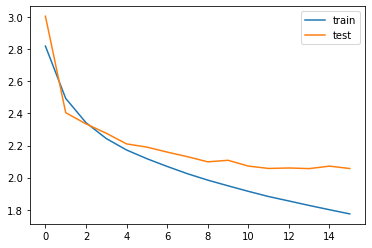

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [0]:
reverse_target_word_index=y_tokenizer.index_word # index: word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

# <font color='blue'>19.建立Model Encoder</font>
---
# <font color='blue'>19.建立Model Decoder</font>

In [0]:
# Encode the input sequence to get the feature vector
# ============================
# ====== encoder_model =======
# ============================
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,)) # 傳入一向量，維度是：LSTM輸出的向量維度
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim)) # 傳入的向量維度是：固定評論長度30 x LSTM輸出的向量維度(每一個詞都轉成LSTM輸出的向量,共有30個詞)

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
# ================================
# ======== decoder_model =========
# ================================
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq) # 
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok'] # 取得start tag的index

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index] # 將index轉成詞
        
        if(sampled_token!='eostok'): # 若最後一個詞不是'eostok'(end tag)，代表還沒結束
            decoded_sentence += ' '+sampled_token # 將預測出來的詞加上空格，放進decoded_sentence裡

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)): 
            stop_condition = True # 最後一個詞是'eostok'(end tag)，或組合的句子>=設定的摘要詞數量上限，代表摘要生成結束

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c # 將"下次要傳入的狀態"，更新為本次輸出的狀態，傳到下一次去

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [0]:
def seq2summary(input_seq): # 將傳入的index句子，去掉start tag, end tag後，將index轉成詞回傳
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']): # 非start tag 也非end tag
            newString=newString+reverse_target_word_index[i]+' ' 
    return newString

def seq2text(input_seq): # 將傳入的句子，去掉第一個詞後，將index轉成詞回傳
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [0]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i])) # 訓練用的評論
    print("Original summary:",seq2summary(y_tr[i])) # 訓練用的摘要(解答)
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len))) # 預測出來的摘要
    print("\n")

Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
Original summary: hour 
Predicted summary:  great product


Review: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
Predicted summary:  great gift


Review: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
Predicted summary:  best coffee ever


Review: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
Predicted summary:  salt


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Predicted summary:  great product


Review: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want ev

This is really cool stuff. Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

#How can we Improve the Model’s Performance Even Further?

Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

I recommend you to **increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax)

Evaluate the performance of your model based on the **BLEU score**

Implement **pointer-generator networks** and **coverage mechanisms**
 



#End Notes

If you have any feedback on this article or any doubts/queries, kindly share them in the comments section over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) and I will get back to you. And make sure you experiment with the model we built here and share your results with me!